# Project purpose

The first goal of this research project is to get familiar with Mobile Robotics Library [MROB](https://github.com/MobileRoboticsSkoltech/mrob), specifically with geometry package which deal with rigid body transformations (RBT) and contains the SO(3) and SE(3) groups implementations.

Besides that, the problem of uncertainty propagation in localization tasks was selected as a research topic. As reference, the paper [1] was selected. It contains examples of numerical experiments which can be used as reference to check implemented algorithms.


# Tasks

* Implement block Cholesky decomposition for singular covariance matrix using pivoting of rows and columns;
* Implement Monte Carlo algorithm for direct uncertainty distribution sampling;
* Implement multivariate gaussian pose noise visualization, that is similar to one from reference paper;
* Implement Monte Carlo compounding;
* Implement pose compounding procedure of 2nd and 4th order from the reference paper;
* Compare all uncertainty propagation methods against the Monte Carlo algorithm;

# Plan
 
1. Compile MROB python bindings from C++ source code https://github.com/MobileRoboticsSkoltech/mrob;
2. Use MROB python bindings to implement methods for uncertainty visualization and propagation according to reference paper and research plan;
3. Compare implemented compound algorithms with direct sampling (Monte Carlo algorithm) similar to reference paper;
4. Publish resulting code on the github https://github.com/nosmokingsurfer/mrob_sandbox

# Expected and achieved results

* All the tasks were completed according to the plan.

# Cholesky decomposition for singular covariance matrix

Cholesky decomposition is used to calculate points on a covariance ellipsoid, which correspond to a particular iso-surface of probability distribution:

$$
\Sigma = L\cdot L^T, \text{ where $\Sigma$ is covariance matrix and $L$ is lower-diagonal matrix}.
$$

To be able to work with different noise models and "turn off" noise along desired axis, but still be able to use decomposition, the preprocessing step required to select covariance sub-matrix which does not contain zero columns and rows and, thus, non-singular and positive defined. The following implementation proposed:

In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

font = {'size': 22}

matplotlib.rc('font', **font)

import numpy as np
import pandas as pd

import scipy
import scipy.stats
import seaborn as sns

from tqdm import tqdm

import mrob

In [2]:
# Here the Cholesky decomposition for singular covariance matrix is implemented
def cholesky(sigma):
    # obtaining map M between original and truncated matrix
    condition =~ (np.all(sigma == 0, axis=1) & (np.all(sigma == 0, axis=0)))
    m = [int(x) for x in condition]
    counter = 0
    res = []
    for el in m:
        if el > 0:
            res.append(counter)
            counter +=1
        else:
            res.append(None)
    M = []    
    for i in range(6):
        tmp = []
        for j in range(6):
            tmp.append([res[i],res[j]])
        
        M.append(tmp)
    M = np.array(M)
    
    # obtaining matrix that is obtained by removing zero columns and rows
    block = (sigma[condition,:])[:,condition]

    # applying regular cholesky decomposition
    L = np.linalg.cholesky(block)
    
    # mapping block decomposition into original matrix
    LL = np.zeros_like(sigma)
    
    for i in range(LL.shape[0]):
        for j in range(LL.shape[1]):
            if all(M[i,j] != None):
                k = M[i,j][0]
                l = M[i,j][1]
                LL[i,j] = L[k,l]
                
    # returning resulting factor
    return LL

Text(86.0, 0.5, "['z', 'y', 'x', 'yaw', 'pitch', 'roll']")

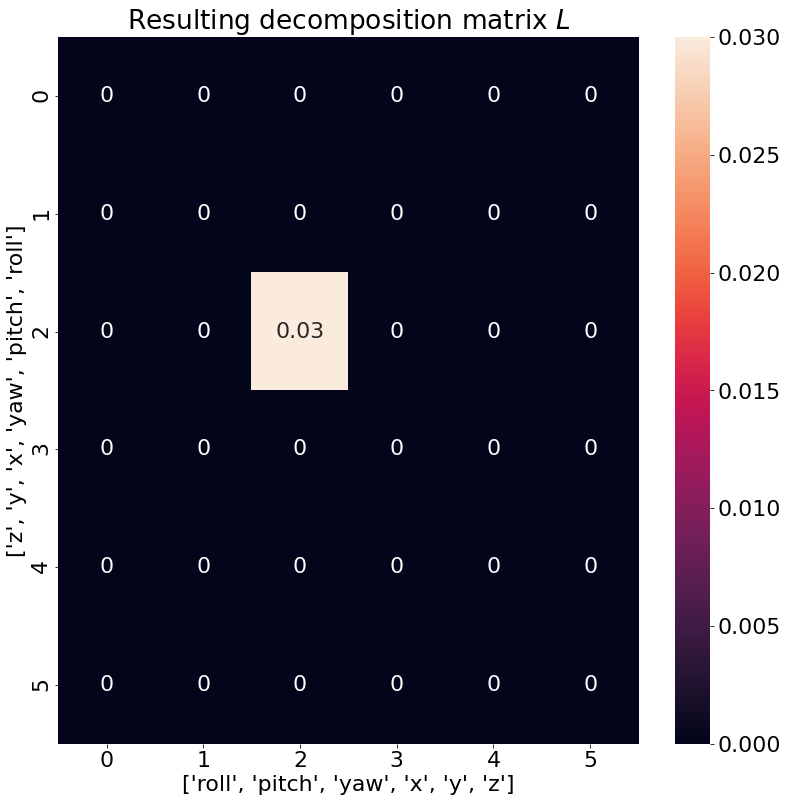

In [3]:
# Testing the implemented method
# The noise is defined only for one coordinate in covariance matrix sigma,
# other coordinates do not have any noise at all
sigma = np.diag([0,0,0.03**2,0,0,0]) 
L = cholesky(sigma)

plt.figure(figsize=(13,13))
plt.title("Resulting decomposition matrix $L$")
sns.heatmap(L,annot=True)
plt.xlabel(["roll","pitch","yaw","x","y","z"])
plt.ylabel(["z","y","x","yaw","pitch","roll"])

To check that obtained factor $L$ generates original matrix $\Sigma$:

In [4]:
print("Decomposition error: ", np.linalg.norm(sigma - L@L.transpose()))

Decomposition error:  0.0


In [5]:
# Testing on some random singular covariance matrices
N = 1_000 # number of test to do
error = 0 # cumulative error
for _ in tqdm(range(N)):
    # Generating random diagonal elements of covariance matrix.
    # Adding +5 to be sure that it will be positive defined.
    tmp = np.random.randn(6) + 5
    
    # Noise for random coordinate is turned off
    tmp[np.random.randint(0,6)] = 0
    
    sigma = np.diag(tmp) # now matrix sigma is singular
    L = cholesky(sigma)
    error += np.linalg.norm(sigma - L@L.transpose())

print("Mean error: {}".format(error/N))

100%|██████████| 1000/1000 [00:00<00:00, 3691.55it/s]

Mean error: 1.3488553953747113e-15


Mean error is approximately equal to zero with machine precision for float type, which is about 1e-16. Thus proposed decomposition works as expected.

# Monte Carlo direct sampling

To obtain distribution of disturbed poses after noise injection, the Monte Carlo algorithm can be used for direct sampling. The noise is injected into SE(3) group using left hand side exponential map update, which is already implemented in current version of MROB library:

In [6]:
# Method for generating random distribution using given mean pose T and noise covariance sigma
def get_mc(T, sigma, mean=[0,0,0,0,0,0], N = 100_000):

    norm_var = scipy.stats.multivariate_normal(mean,sigma,allow_singular=True)

    xi = norm_var.rvs(N)
    
    propagated = []
    for i in range(len(xi)):
        tmp = mrob.geometry.SE3(T)
        tmp.update_lhs(xi[i])
        propagated.append(tmp)
        
    poses = np.array([x.t() for x in propagated])
    poses = poses.reshape((-1,3))
    
    xi = np.array([x.Ln() for x in propagated])
    return poses, xi

In [7]:
# generating noise samples according to given covariance matrix

# Noise has zero mean values
mean = np.zeros(6)

# Noise covariance matrix
sigma = np.diag([0,0,0.1,0.001,0.01,0])

poses, xi = get_mc(mrob.geometry.SE3([0,0,0,1,0,0]), sigma, mean,N=1_000_0)

To visualize the distribution the $(x,y)$ coordinates of poses plotted on a scatter plot:

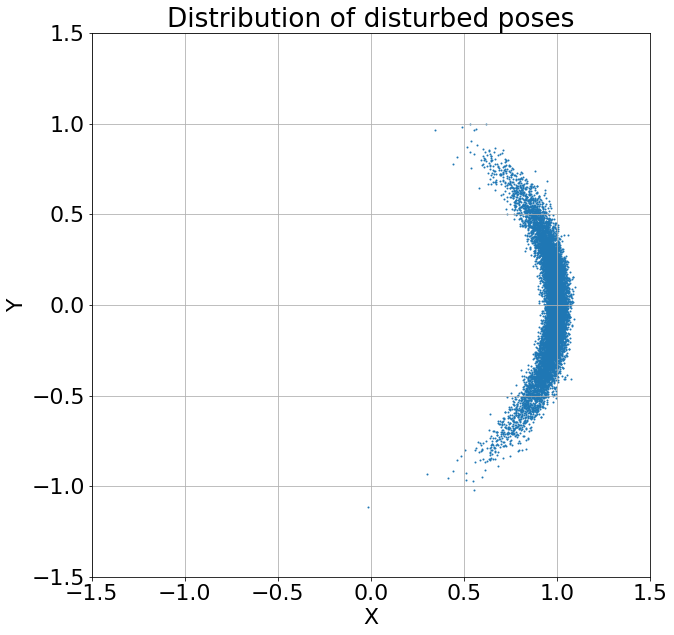

In [8]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.title('Distribution of disturbed poses')
plt.scatter(poses[:,0],poses[:,1],s=1)
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.show()

It it clear that the dominating yaw angle noise causes so-called "banana-shaped" distribution in $(x,y)$ coordinates.

# Covariance visualization

Similar to the lecture [[2]](https://github.com/MobileRoboticsSkoltech/Perception-in-Robotics-course-T3-2021-Skoltech/blob/master/L02/L02_gaussians_class.pdf), instead of direct distribution sampling, the ellipsoid main circumferences can be projected on to the ground plane $(x,y)$ using the Cholesky decomposition:

$$
\Sigma = L\cdot L^T
$$

we have matrix $L$ that is used to obtain points on covariance ellipsoid $\Sigma$:

$$
r_{\Sigma} = L\cdot r_I,
\tag{1}
\label{unit}
$$

where $r_I$ are big circles on a sphere, which go through every pair of coordinate axis. If $1-\sigma$ quantile visualized, then $r_I$ are sampled from unitary sphere. If $K-\sigma$ quantiles required, then $r_I$ is sampled from the sphere of radius $K$. Basically, the expression ($\ref{unit}$) transforms standard distribution $N(0,I)$ into given normal distribution $N(0,\Sigma)$ which is a subject for visualization.

Covariance matrix $\Sigma$ is the size of 6x6, but in this project we will consider body transformations that correspond only to motion on a flat surface, i.e. the noise for roll, pitch and z coordinates will be turned off for visualization and instead of 6D ellipsoid the 3D ellipsoid for **(yaw,x,y)** coordinates will be visualized.

The following naive implementation proposed. It sequentially samples points from big circles which go through pairs of axis : **(yaw, x), (yaw, y), (x, y)**. Besides that, ellipsoid axis visualized for **(yaw, x, y)**.

In [9]:
def sigma_visualize(T, sigma, N=100, K=[1,1], label="", color=None):
    N = 100
    
    colors = list(matplotlib.colors.CSS4_COLORS.keys())
    
    if color is None:
        color = colors[np.random.randint(0, len(colors))]
    
    plt.plot(T.t()[0], T.t()[1],'x',color=color)
    plt.annotate(label, (T.t()[0], T.t()[1]))
    A = cholesky(sigma)
    for k in set(K):
        # plotting yaw & x plane
        labels = ['+yaw','-yaw','+x','-x']
        points = []
        points.append([0,0,k,0,0,0])
        points.append([0,0,-k,0,0,0])
        points.append([0,0,0,k,0,0])
        points.append([0,0,0,-k,0,0])


        for i in range(N+1):
            points.append([0,0,k*np.cos(2*np.pi/N*i), k*np.sin(2*np.pi/N*i),0,0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[4:,0],poses[4:,1], label="{}-sigma yaw & x".format(k), color=color)
    
        for i in range(len(labels)):
#             plt.annotate(labels[i],xy = (poses[i,0],poses[i,1]), xytext = (poses[i,0]+0.01,poses[i,1]+0.01))
            plt.plot(poses[i,0],poses[i,1],'x',color=color)
        
        # plotting x & y plane
        labels = ['+x','-x','+y','-y']
        points = []
        points.append([0,0,0,k,0,0])
        points.append([0,0,0,-k,0,0])
        points.append([0,0,0,0,k,0])
        points.append([0,0,0,0,-k,0])


        for i in range(N+1):
            points.append([0,0,0,k*np.cos(2*np.pi/N*i), k*np.sin(2*np.pi/N*i),0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[4:,0],poses[4:,1], label="{}-sigma x & y".format(k), color=color)
    
        for i in range(len(labels)):
#             plt.annotate(labels[i],xy = (poses[i,0],poses[i,1]), xytext = (poses[i,0]+0.01,poses[i,1]+0.01))
            plt.plot(poses[i,0],poses[i,1],'x',color=color)
    

    
        # plotting yaw & y plane
        labels = ['+yaw','-yaw','+y','-y']
        points = []
        points.append([0,0,k,0,0,0])
        points.append([0,0,-k,0,0,0])
        points.append([0,0,0,0,k,0])
        points.append([0,0,0,0,k,0])


        for i in range(N+1):
            points.append([0,0,k*np.cos(2*np.pi/N*i),0, k*np.sin(2*np.pi/N*i),0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[4:,0],poses[4:,1], label="{}-sigma yaw & y".format(k),color=color)
    
        for i in range(len(labels)):
#             plt.annotate(labels[i],xy = (poses[i,0],poses[i,1]), xytext = (poses[i,0]+0.01,poses[i,1]+0.01))
            plt.plot(poses[i,0],poses[i,1],'x',color=color)
        # plotting yaw axis of ellipsoid
        points = []

        for i in range(N+1):
            points.append([0,0,k - i*(2*k)/N, 0,0,0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[:,0],poses[:,1],color=color)
        
        # plotting x axis
        points = []
        for i in range(N+1):
            points.append([0,0,0,k - i*(2*k)/N,0,0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[:,0],poses[:,1],color=color)
        
        # plotting y axis
        points = []

        for i in range(N+1):
            points.append([0,0,0,0,k - i*(2*k)/N, 0])

        points = np.array(points)
        
        points_img = np.dot(A,points.transpose()).transpose()

        propagated = []

        for i in range(len(points_img)):
            tmp = mrob.geometry.SE3(T)
            tmp.update_lhs(points_img[i])
            propagated.append(tmp)
        poses = np.array([x.t() for x in propagated])
        poses = poses.reshape((-1,3))
        
        plt.plot(poses[:,0],poses[:,1],color=color)

    plt.xlabel("X")
    plt.ylabel("Y")

Let's visualize some simple test examples and compare results against the Monte Carlo direct sampling results:

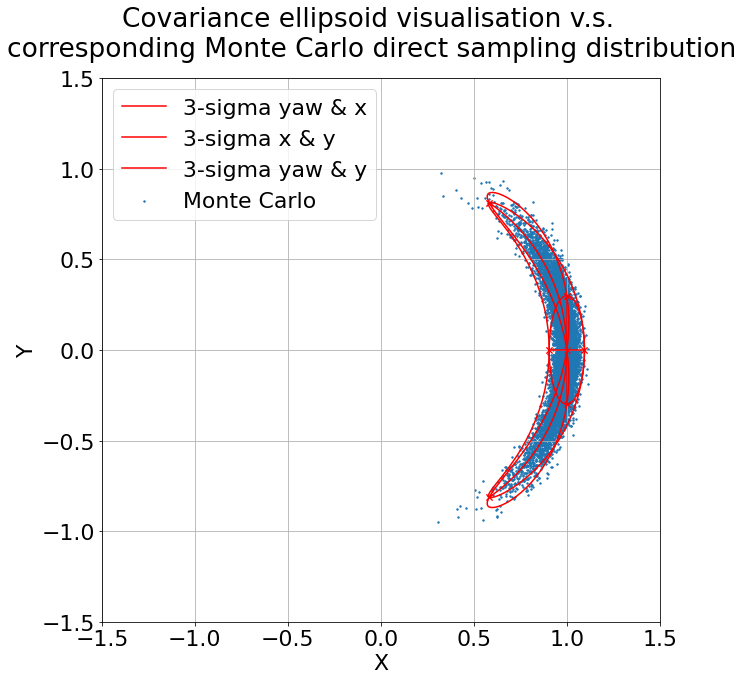

In [10]:
plt.figure(figsize=(10,10))
plt.suptitle('Covariance ellipsoid visualisation v.s. \ncorresponding Monte Carlo direct sampling distribution')
sigma = np.diag([0,0,0.1,0.001,0.01,0])
poses, xi = get_mc(mrob.geometry.SE3([0,0,0,1,0,0]), sigma, mean,N=1_000_0)
sigma_visualize(mrob.geometry.SE3([0,0,0,1,0,0]), sigma=sigma,N = 100, K=[3], color='red')
plt.scatter(poses[:,0],poses[:,1], label='Monte Carlo',s=2)

plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.grid()
plt.legend()
plt.show()

Two visualizations correspond to each other. Let's try now another pose instead of simple shift along $x$ axis.

In [11]:
# adding some yaw rotation
sigma = np.diag([0,0,0.1,0.001,0.01,0])
poses, xi  = get_mc(mrob.geometry.SE3([0,0,0.9,1,0,0]), sigma)

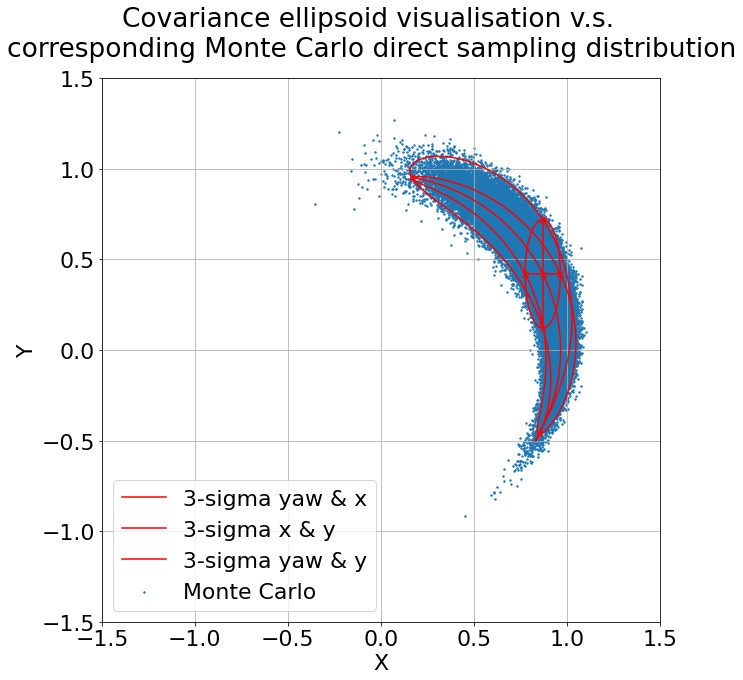

In [12]:
plt.figure(figsize=(10,10))
plt.suptitle('Covariance ellipsoid visualisation v.s. \ncorresponding Monte Carlo direct sampling distribution')


sigma_visualize(mrob.geometry.SE3([0,0,0.9,1,0,0]), sigma=sigma,N = 100, K=[3],color='red')
plt.scatter(poses[:,0],poses[:,1], label='Monte Carlo',s = 2)

plt.xlim([-1.5,1.5])
plt.ylim([-1.5,1.5])
plt.grid()
plt.legend()
plt.show()

The above plotted graphs show that Monte Carlo and ellipsoid "wire-frame" projections correspond to each other.

# Pose compounding

Suppose there are two sequential pose increments:
    
$$
 \{T_1, \Sigma_1\}, \{T_2, \Sigma_2\}
$$

The pose compound procedure allow to obtain the resulting pose and covariance:

$$
    COMPOUND(\{T_1, \Sigma_1\}, \{T_2, \Sigma_2\}) \to \{T,\Sigma\}
$$

## Monte Carlo Compound

Monte Carlo direct sampling is slow-but-accurate way to obtain pose compounding. The following formulas are used:

$$
T = T_1 \cdot T_2 - \text{ is the mean of resulting distribution}.
$$


The covariance calculated as follows:

$$
\Sigma_{mc} = \frac{1}{M}\sum \xi_m \xi_m^T\\
\xi_m = Ln(T_m T^{-1})^{\vee}\\
T_m = exp(\xi_{m_1}^\wedge)T_1 exp(\xi_{m_2}^\wedge)T_2
$$

In [13]:
def compound_mc(T_1, sigma_1, T_2, sigma_2, M = 10_000):
    
    # generating distributions
    p1, xi1 = get_mc(T_1, sigma_1, N=M)
    
    p2, xi2 = get_mc(T_2, sigma_2, N=M)
    
    # mean pose
    T = T_1.mul(T_2)
      
    sigma_mc = np.zeros_like(sigma_1)
    
    xi_m = []
    
    for i in range(xi1.shape[0]):
        
        T_r = mrob.geometry.SE3(T_2)
        T_r.update_lhs(np.array(xi2[i]))
        
        T_l = mrob.geometry.SE3(T_1)
        T_l.update_lhs(np.array(xi1[i]))
        
        T_m = T_l.mul(T_r)
    
        xi_m.append(T_m.mul(T.inv()).Ln())
        
    # calculating cavirance of xi points coordinates
    sigma_mc = np.cov(np.array(xi_m).transpose())
    return T, sigma_mc

In [14]:
# defining two poses with uncertainty to compound
xi_1 = np.array([0,0,0,0.5,0,0])
T_1 = mrob.geometry.SE3(xi_1)
sigma_1 = np.diag([0,0,0.01,0.01,0.01,0])

xi_2 = np.array([0,0,0.5,1.0,0,0])
T_2 = mrob.geometry.SE3(xi_2)
sigma_2 = np.diag([0,0,0.1,0.01,0.01,0])

T,sigma = compound_mc(T_1, sigma_1, T_2, sigma_2, M=100_000)

Text(86.0, 0.5, "['z', 'y', 'x', 'yaw', 'pitch', 'roll']")

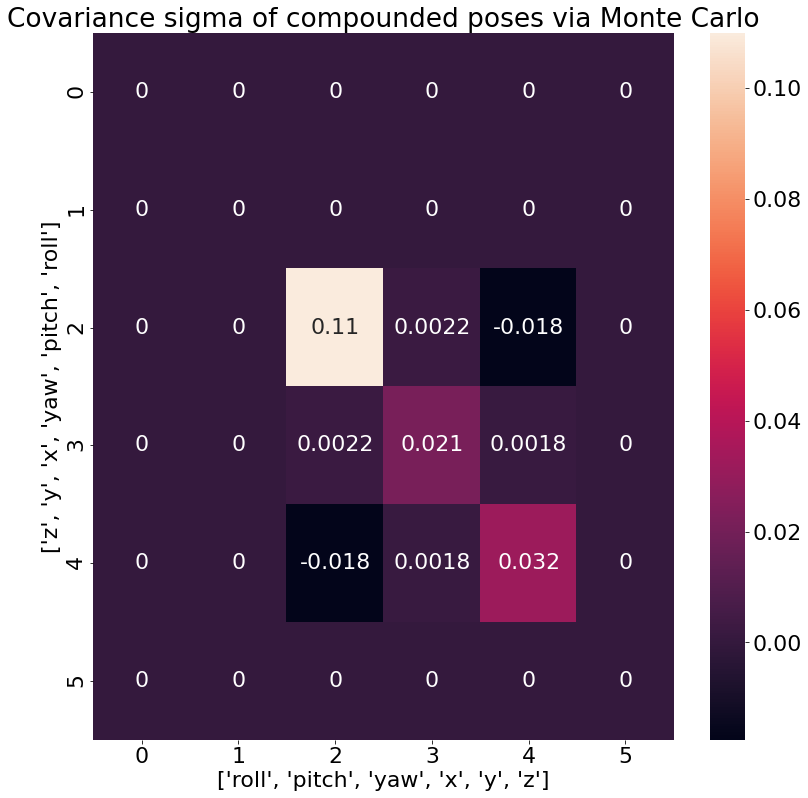

In [15]:
plt.figure(figsize=(13,13))

plt.title("Covariance sigma of compounded poses via Monte Carlo")
sns.heatmap(sigma,annot=True)
plt.xlabel(["roll","pitch","yaw","x","y","z"])
plt.ylabel(["z","y","x","yaw","pitch","roll"])

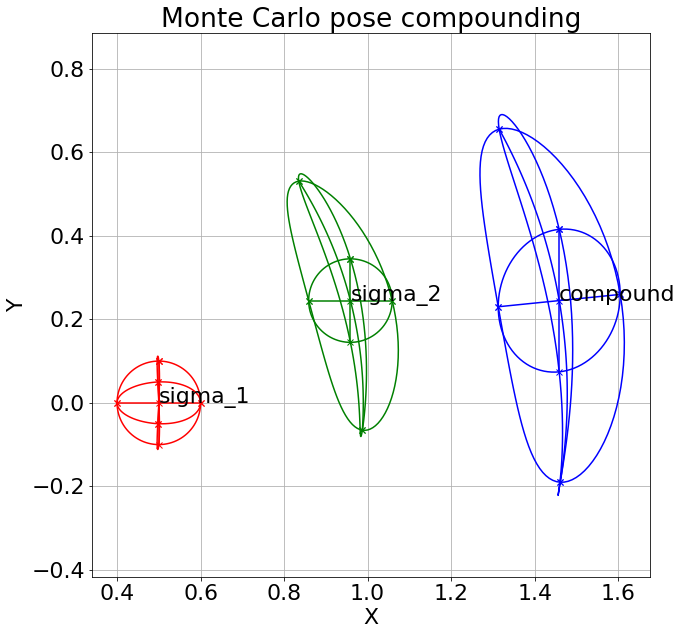

In [16]:
plt.figure(figsize=(10,10))

plt.title('Monte Carlo pose compounding')
sigma_visualize(T_1, sigma_1, label='sigma_1',color='r')
sigma_visualize(T_2, sigma_2, label='sigma_2',color='g')
sigma_visualize(T,sigma,label='compound',color='b')
plt.grid()
plt.axis('equal')
plt.show()


## Second order compounding

Second order pose compounding has the following equations:

$$
T = T_1 \cdot T_2\\
\Sigma = \Sigma_1 + \Sigma^\prime_2, \text{where $\Sigma^\prime_2 = \mathcal{T_1}\Sigma_2\mathcal{T_1}^{T}$ and $\mathcal{T_1} = Adj(T_1)$}
$$

The implementation as follows:

In [17]:
def compound_2nd(T1, sigma1, T2, sigma2):
    T = T_1.mul(T_2)
    T_1_adj = T_1.adj()
    sigma_2_ = T_1_adj@sigma_2@T_1_adj.transpose()
    sigma = sigma_1 + sigma_2_
    return T, sigma

In [18]:
T,sigma = compound_2nd(T_1, sigma_1, T_2, sigma_2)

Text(86.0, 0.5, "['z', 'y', 'x', 'yaw', 'pitch', 'roll']")

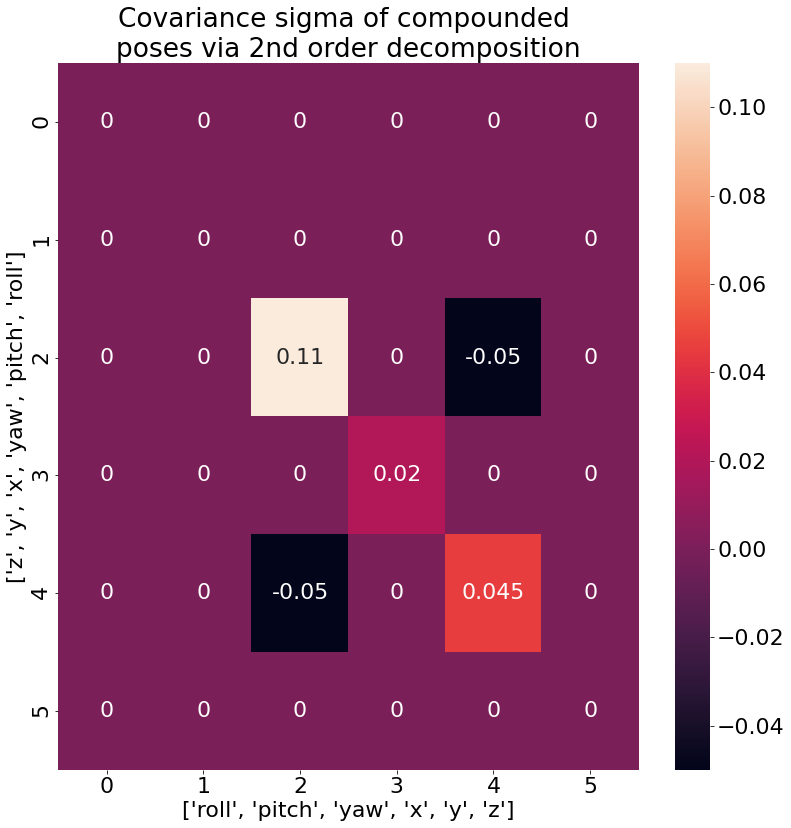

In [19]:
plt.figure(figsize=(13,13))
plt.title("Covariance sigma of compounded \nposes via 2nd order decomposition")
sns.heatmap(sigma,annot=True)
plt.xlabel(["roll","pitch","yaw","x","y","z"])
plt.ylabel(["z","y","x","yaw","pitch","roll"])

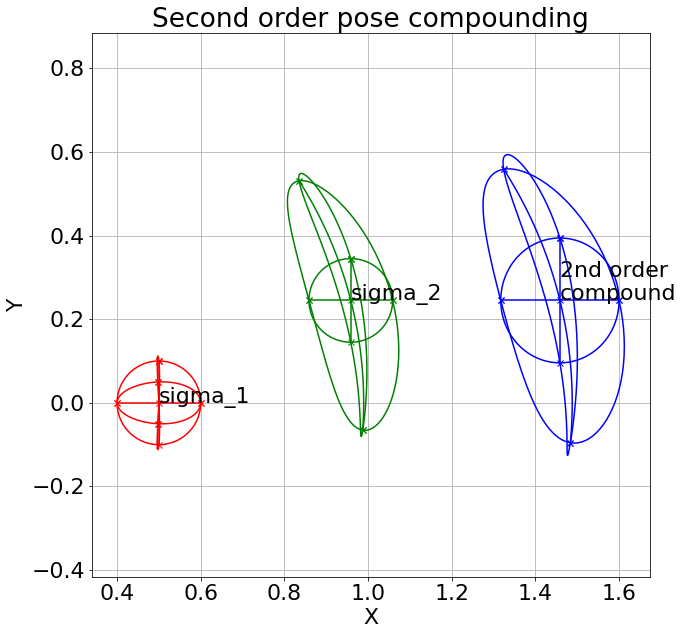

In [20]:
plt.figure(figsize=(10,10))
plt.title('Second order pose compounding')
sigma_visualize(T_1, sigma_1, label='sigma_1',color='r')
sigma_visualize(T_2, sigma_2, label='sigma_2',color='g')
sigma_visualize(T,sigma, label='2nd order \ncompound',color='b')
plt.grid()
plt.axis('equal')
plt.show()


## Fourth order

In the original paper [1] the coordinate order is the opposite to one that is used in MROB. To be able to use the formulas for 4th order pose compounding with minimal changes the following block permutation is required:

$$
\left[
\begin{array}{c}
A & C\\
C^T & B\\
\end{array}
\right] \iff
\left[
\begin{array}{c}
B & C^T\\
C & A\\
\end{array}
\right]
$$

In [21]:
# method to do block matrix permutations
def sigma_permute(sigma):
    s = np.zeros_like(sigma)
    # top left block
    s[:3,:3] = sigma[3:,3:]
    
    # top right block
    s[:3,3:] = sigma[3:,:3]
    
    # bottom right block
    s[3:,3:] = sigma[:3,:3]
    
    # bottom left block
    s[3:,:3] = sigma[:3,3:]
    
    return s

Note that method `sigma_permute` when applied twice, return the original matrix. Thus, the inverse of `sigma_permute` is itself:

In [22]:
np.linalg.norm(sigma_1 - sigma_permute(sigma_permute(sigma_1)))

0.0

In [23]:
def op1(A):
    return -np.eye(A.shape[0])*A.trace() + A

def op2(A,B):
    return op1(A)@op1(B) + op1(B@A)

In [24]:
def compound_4th(T_1, sigma_1, T_2, sigma_2):
    # applying 2nd order to get part of 4th order decomposition
    T, sigma = compound_2nd(T_1, sigma_1, T_2, sigma_2)
    
    T_1_adj = T_1.adj()
    
    _sigma_2 = T_1_adj @ sigma_2 @ T_1_adj.transpose()
    
    # map all sigma into [rho, phi] order
    tmp = sigma_permute(sigma)
    s1 = sigma_permute(sigma_1)
    s2 = sigma_permute(_sigma_2)
    
    # using equations from reference paper
    
    sigma_1_rho_rho = s1[:3, :3]
    sigma_1_rho_phi = s1[:3, 3:]
    sigma_1_phi_phi = s1[3:, 3:]
    
    _sigma_2_rho_rho = s2[:3, :3]
    _sigma_2_rho_phi = s2[:3, 3:]
    _sigma_2_phi_phi = s2[3:, 3:]
    
    A_1 = np.zeros((6,6))
    A_1[:3, :3] = op1(sigma_1_phi_phi)
    A_1[:3, 3:] = op1(sigma_1_rho_phi + sigma_1_rho_phi.transpose())
    A_1[3:, 3:] = op1(sigma_1_phi_phi)
    
    _A_2 = np.zeros((6,6))
    _A_2[:3, :3] = op1(_sigma_2_phi_phi)
    _A_2[:3, 3:] = op1(_sigma_2_rho_phi + _sigma_2_rho_phi.transpose())
    _A_2[3:, 3:] = op1(_sigma_2_phi_phi)
    
    B_rho_rho = op2(sigma_1_phi_phi, _sigma_2_rho_rho) + \
        op2(sigma_1_rho_phi.transpose(), _sigma_2_rho_phi) + \
        op2(sigma_1_rho_phi,_sigma_2_rho_phi.transpose()) + \
        op2(sigma_1_rho_rho, _sigma_2_phi_phi)
    
    B_rho_phi = op2(sigma_1_phi_phi,_sigma_2_rho_phi.transpose()) + \
        op2(sigma_1_rho_phi.transpose(),_sigma_2_phi_phi)
    
    B_phi_phi = op2(sigma_1_phi_phi, _sigma_2_phi_phi)
    
    B = np.zeros_like(sigma_1)
    B[:3,:3] = B_rho_rho
    B[:3,3:] = B_rho_phi
    B[3:,:3] = B_rho_phi.transpose()
    B[3:,3:] = B_phi_phi
    
    tmp += 1./12*(A_1@s2 + \
                   s2@A_1.transpose() + \
                   _A_2@s1 + \
                   s1@ _A_2.transpose()) + 0.25*B
    
    # mapping resulting sigma into [phi,rho] order
    res = sigma_permute(tmp)
    
    return T, res
    

In [25]:
T,sigma = compound_4th(T_1, sigma_1, T_2, sigma_2)

Text(86.0, 0.5, "['z', 'y', 'x', 'yaw', 'pitch', 'roll']")

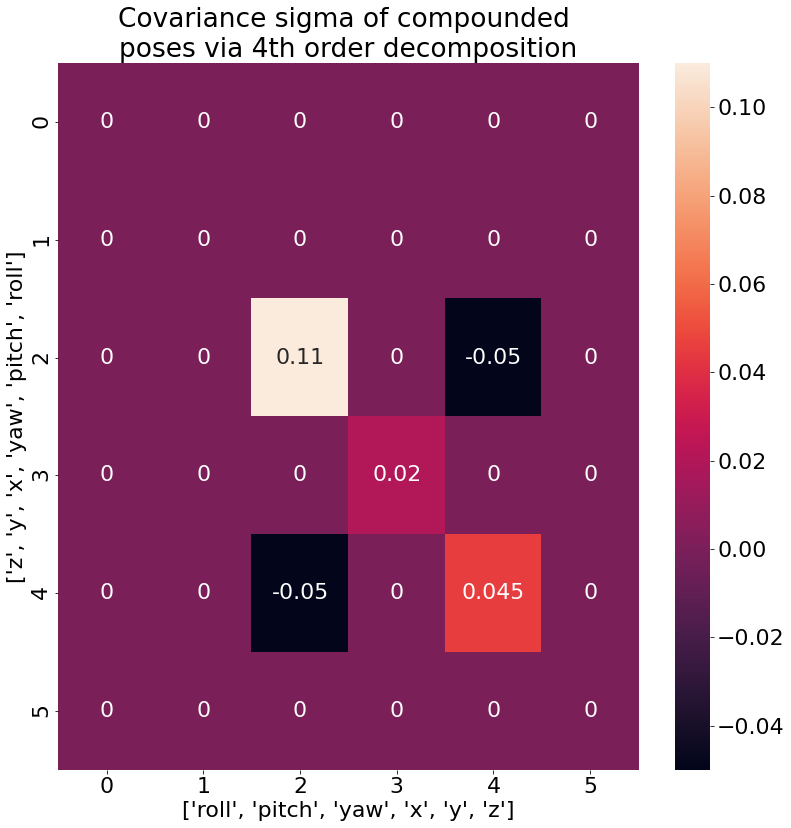

In [26]:
plt.figure(figsize=(13,13))
plt.title("Covariance sigma of compounded \nposes via 4th order decomposition")
sns.heatmap(sigma,annot=True)
plt.xlabel(["roll","pitch","yaw","x","y","z"])
plt.ylabel(["z","y","x","yaw","pitch","roll"])

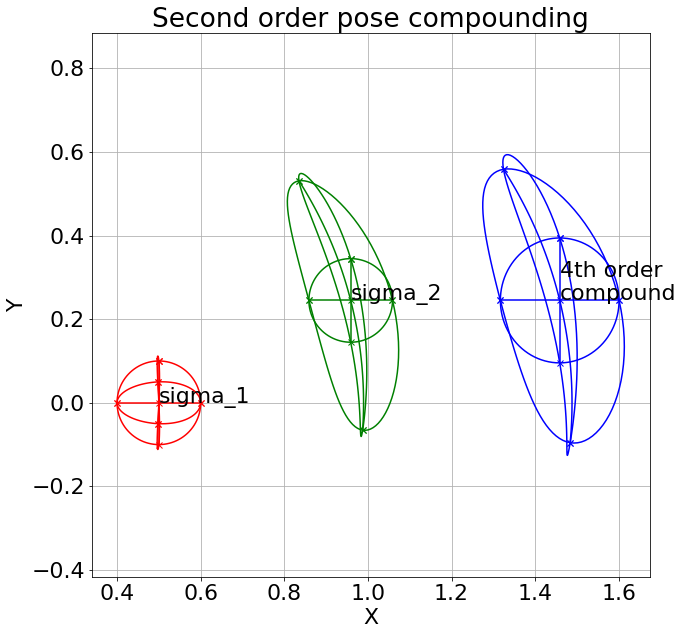

In [27]:
plt.figure(figsize=(10,10))
plt.title('Second order pose compounding')
sigma_visualize(T_1, sigma_1, label='sigma_1',color='r')
sigma_visualize(T_2, sigma_2, label='sigma_2',color='g')
sigma_visualize(T,sigma, label='4th order \ncompound',color='b')
plt.grid()
plt.axis('equal')
plt.show()


Let's visualize all compound methods on a single plot:

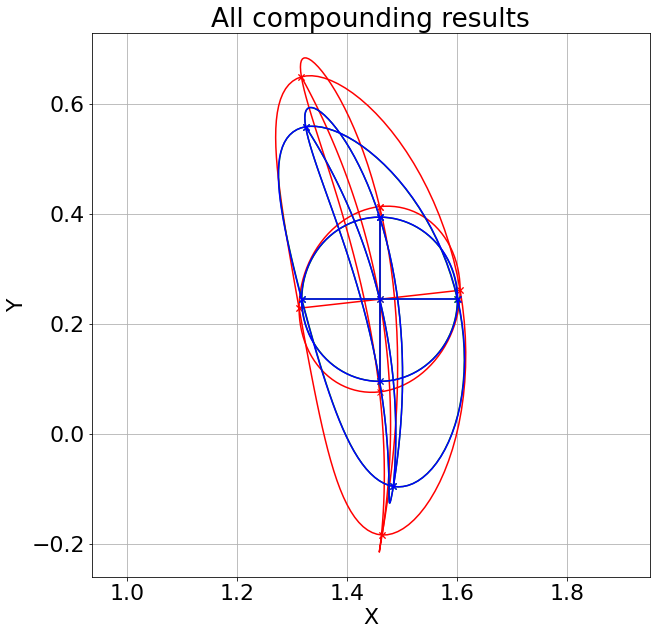

In [28]:
plt.figure(figsize=(10,10))
plt.title('All compounding results')
T_mc, sigma_mc = compound_mc(T_1, sigma_1, T_2, sigma_2)
T2,sigma2 = compound_2nd(T_1, sigma_1, T_2, sigma_2)
T4,sigma4 = compound_4th(T_1, sigma_1, T_2, sigma_2)

sigma_visualize(T_mc,sigma_mc, color='r')
sigma_visualize(T2,sigma2, color='g')
sigma_visualize(T4,sigma4, color='b')
plt.grid()
plt.axis('equal')
plt.show()

For above depicted case the 2nd and the 4th order compounding results are identical.

# Comparison

Second and fourth order compared against Monte Carlo for various noise scales:

In [29]:
M = 1_000_00

err_1 = []
err_2 = []

alphas = np.arange(0,1.05,0.05)

for alpha in tqdm(alphas):
    xi_1 = np.array([np.pi/6,0,0,0,2,0])
    T_1 = mrob.geometry.SE3(xi_1)
    sigma_1 = alpha*np.diag([1/2,1,1/2,10,5,5])

    xi_2 = np.array([0,np.pi/4,0,0,0,1])
    T_2 = mrob.geometry.SE3(xi_2)
    sigma_2 = alpha*np.diag([1/2,1/2,1,5,10,5])
    
    T, sigma_mc =  compound_mc(T_1, sigma_1, T_2, sigma_2, M=M)
    
    
    t1,s1 = compound_2nd(T_1, sigma_1, T_2, sigma_2)
    t2,s2 = compound_4th(T_1, sigma_1, T_2, sigma_2)
    
    
    err_1.append(np.linalg.norm(sigma_mc - s1))
    err_2.append(np.linalg.norm(sigma_mc - s2))

100%|██████████| 21/21 [00:39<00:00,  1.86s/it]


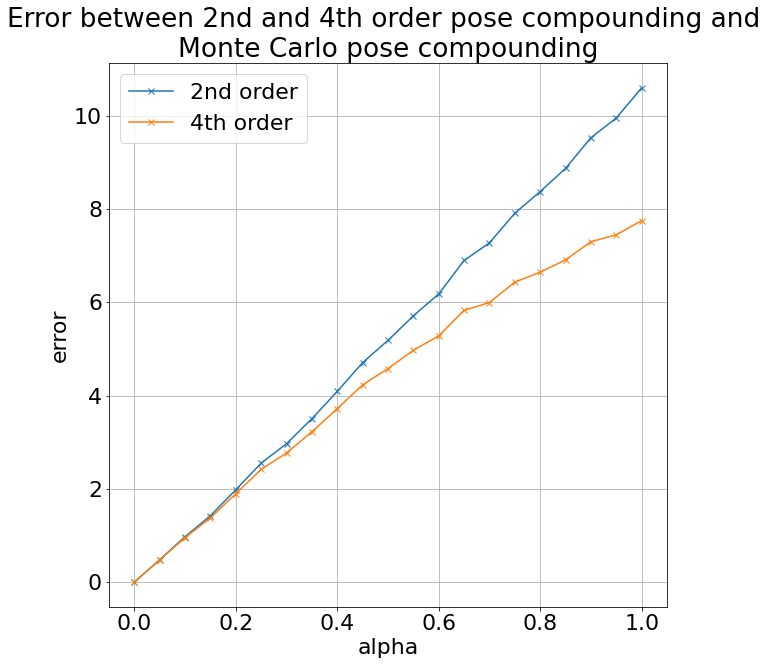

In [30]:
plt.figure(figsize=(10,10))
plt.title('Error between 2nd and 4th order pose compounding and \nMonte Carlo pose compounding')
plt.plot(alphas,err_1,'-x', label='2nd order')
plt.plot(alphas,err_2,'-x', label='4th order')
plt.xlabel('alpha')
plt.ylabel('error')
plt.grid()
plt.legend()

The error asymptotics differs from one provided in the paper. This can be caused by difference in experiment conditions.

# Conclusions

1. All implemented compound algorithms correspond to each other at a first glance.
2. There is some numerical difference between 2nd and 4th order but it is unclear if this difference costs its complexity. Further numerical investigation required to evaluate how this error maps in pose coordinates.

# References

1. Associating Uncertainty With Three-Dimensional Poses for Use in Estimation Problems by Timothy D. Barfoot, Member, IEEE, and Paul T. Furgale, Member, IEEE
2. Perception in Robotics Skoltech lectures by Gonzalo Ferrer. https://github.com/MobileRoboticsSkoltech/Perception-in-Robotics-course-T3-2021-Skoltech/blob/master/L02/L02_gaussians_class.pdf